### Yukawa

In [15]:
import os
import csv
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

In [16]:
Z = 2

##### Functions

In [17]:
x = sp.Symbol('x')
r = sp.Symbol('r')

# Página 338
def laguerre(j, x):
    f = sp.exp(-x) * x**j
    for n in range(j):
        f = sp.diff(f, x)

    f = sp.exp(x) * f

    globals()[f'L_{j}'] = f

    return sp.simplify(globals()[f'L_{j}'])

# Página 339
def laguerre_associated(n, l, Z):
    j = n-l-1
    k = 2*l+1

    f = laguerre(j+k, x)

    for i in range(k):
        f = sp.diff(f, x)

    globals()[f'L_{j}^{k}'] = (-1)**k * f
    return globals()[f'L_{j}^{k}'].subs(x, 2*r*Z/n)

# Página 347
def radial_wavefunction(n, l, Z):
    """
    Calcula la función de onda radial para un estado dado (n, l) en un átomo con número atómico Z.
    
    Parámetros:
        n (int): Número cuántico principal.
        l (int): Número cuántico azimutal.
        Z (float): Número atómico (número de protones en el núcleo).
    
    Retorna:
        La función de onda radial.
    """
    
    # Polinomio de Laguerre generalizado
    laguerre_poly = laguerre_associated(n, l, Z)
    
    # Factor de normalización
    normalization_factor = sp.sqrt((2*Z/n)**3 * sp.factorial(n-l-1) / (2*n*sp.factorial(n+l)**3))
    
    # Exponencial
    exponential = sp.exp(-Z*r/n)
    
    # Función de onda radial
    radial_wavefunction = normalization_factor * exponential * (2*r*Z/n)**l * laguerre_poly
    
    return radial_wavefunction

In [18]:
def save_to_csv(folder, name, data):
    alphas = data[0]
    energies = data[1]

    if not os.path.exists(folder):
        os.makedirs(folder)

    nombre_archivo = f'{name}.csv'
    ruta_archivo = os.path.join(folder, nombre_archivo)

    with open(ruta_archivo, mode='w', newline='') as archivo_csv:
        escritor_csv = csv.writer(archivo_csv)
        escritor_csv.writerow(['alpha', 'energy'])
        for x, y in zip(alphas, energies):
            escritor_csv.writerow([x, y])

##### The Radial Wavefunction Solutions

In [19]:
n_max = 10

for n in range(1, n_max+1):
    for l in range(n):
        globals()[f'u_{n}{l}'] = r * radial_wavefunction(n, l, Z)
        globals()[f'dd_u_{n}{l}'] = sp.diff(globals()[f'u_{n}{l}'], r, r)

##### Barrido de alpha

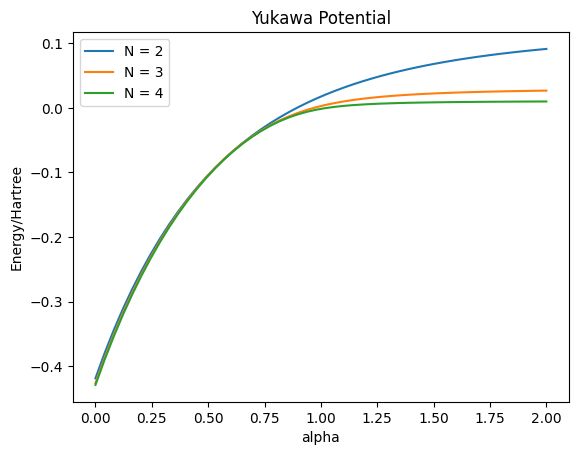

In [20]:
alphas = np.linspace(0, 2, 50)
states = [2, 3, 4]

for N in states:
    energies = []

    for alpha in alphas:
        h_pq = []
        for i in range(1, N+1):
            h_pq.append([])
            for j in range(1, N+1):
                globals()[f'h_{i}{j}'] = -1/2 * sp.integrate(globals()[f'u_{i}0']*globals()[f'dd_u_{j}0'], (r, 0, sp.oo)) \
                                        - sp.integrate(globals()[f'u_{i}0']*globals()[f'u_{j}0'] * sp.exp(-alpha*r)/r, (r, 0, sp.oo))
                h_pq[i-1].append(globals()[f'h_{i}{j}'])
        
        h_pq_matrix = sp.Matrix(h_pq)
        eigenvalue = np.min(list(h_pq_matrix.eigenvals().keys()))
        energies.append(eigenvalue)

    save_to_csv(f'results_{Z}_different_base', f'N={N}', [alphas, energies])
    plt.plot(alphas, energies, marker='', linestyle='-', label=f'N = {N}')

plt.xlabel('alpha')
plt.ylabel('Energy/Hartree')
plt.title('Yukawa Potential')
plt.legend()
plt.show()

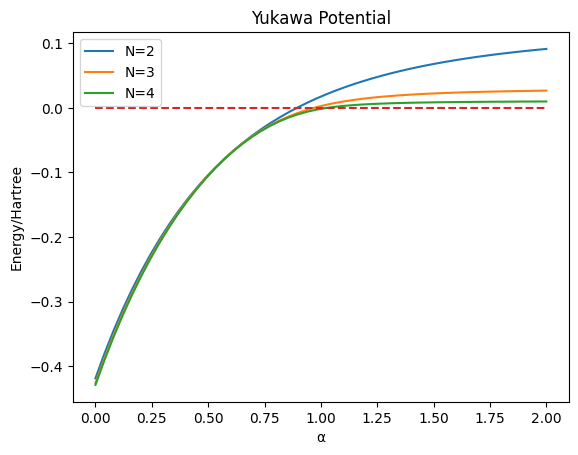

In [21]:
import os
import csv

folder = f'results_{Z}_different_base'
files = [file for file in os.listdir(folder) if file.endswith('.csv')]

def ordenar_por_numero(nombre_archivo):
    # Obtener el número del nombre del archivo
    numero = int(nombre_archivo.split('=')[1].split('.')[0])
    return numero

files = sorted(files, key=ordenar_por_numero)

for file in files:
    alphas = []
    energies = []

    with open(f'{folder}/{file}', newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)

        for row in reader:
            alphas.append(float(row[0]))
            energies.append(float(row[1]))

    plt.plot(alphas, energies, marker='', linestyle='-', label=file.split('.')[0])

energies = np.linspace(0, 0, 50).astype(int)
plt.plot(alphas, energies, marker='', linestyle='--')

plt.xlabel('α')
plt.ylabel('Energy/Hartree')
plt.title('Yukawa Potential')
plt.legend()
plt.savefig(f'{folder}/yukawa_potential')
plt.show()